In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from statsmodels.regression.rolling import RollingOLS
import pandas as pd
from math import erfc

In [3]:
# Note that norm().cdf() from scipy is sometimes slow
def normcdf(x):
    '''Standard normal CDF'''
    return erfc(-x / np.sqrt(2)) / 2


def get_cds(S, sigma_S, r, D, Lbar, llambda, R, T):
    '''Calculate CDS'''
    V0 = S + Lbar * D
    d = V0 / (Lbar * D) * np.exp(llambda**2)
    sigma = sigma_S * S / (S + Lbar * D)
    A0 = np.sqrt(sigma**2*0 + llambda**2)
    AT = np.sqrt(sigma**2*T + llambda**2)
    xi = (llambda/sigma)**2
    z = np.sqrt(0.25 + 2 * r / sigma**2)
    Gxi = d**(z+0.5) * \
        normcdf(-np.log(d)/(sigma*np.sqrt(xi)) - z*sigma*np.sqrt(xi)) + \
        d**(-z+0.5) * \
        normcdf(-np.log(d)/(sigma*np.sqrt(xi)) + z*sigma*np.sqrt(xi))
    GT = d**(z+0.5) * \
        normcdf(-np.log(d)/(sigma*np.sqrt(T)) - z*sigma*np.sqrt(T)) + \
        d**(-z+0.5) * \
        normcdf(-np.log(d)/(sigma*np.sqrt(T)) + z*sigma*np.sqrt(T))
    Txi = T + xi
    GTxi = d**(z+0.5) * \
        normcdf(-np.log(d)/(sigma*np.sqrt(Txi)) - z*sigma*np.sqrt(Txi)) + \
        d**(-z+0.5) * \
        normcdf(-np.log(d)/(sigma*np.sqrt(Txi)) + z*sigma*np.sqrt(Txi))
    q0 = normcdf(-A0/2+np.log(d)/A0) - d*normcdf(-A0/2-np.log(d)/A0)
    qT = normcdf(-AT/2+np.log(d)/AT) - d*normcdf(-AT/2-np.log(d)/AT) 
    HT = np.exp(r*xi) * (GTxi - Gxi)
    cds = 100 * r*(1-R) * (1-q0+HT) / (q0-qT*np.exp(-r*T)-HT)    # in %
    rpv01 = (q0 - qT*np.exp(-r*T) - HT) / r
    # Return variables other than cds for later use
    return {
        'cds': cds, 
        'rpv01': rpv01, 
        'q0': q0, 
        'qT': qT, 
        'GTxi': GTxi, 
        'GT': GT
    }

In [5]:
dfboeing = pd.read_csv('Boeing.csv')
dfboeing = dfboeing.dropna(axis=1, how='all')
dfboeing['date'] = pd.to_datetime(dfboeing['date'])
dfboeing.sort_values('date', inplace=True)
llambda = 0.3
R = 0.5
Lbar = 0.75
T = 5

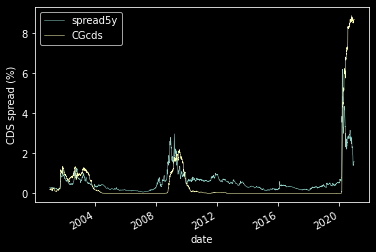

In [6]:
dfboeing['CGcds'] = [
    get_cds(x.S, x.sigma_stock, x.r, x.D, Lbar, llambda, R, T)['cds'] 
    for x in dfboeing.itertuples()
]
# Plot
fig, ax = plt.subplots()
dfboeing.set_index('date')[['spread5y', 'CGcds']].plot(ax=ax, linewidth=0.5)
ax.set_ylabel('CDS spread (%)')
fig.savefig('Q3_a.png', dpi=150)


## B

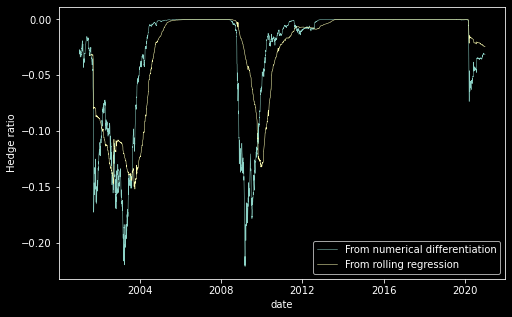

In [7]:


def get_pd_from_numdiff(S0, sigma_S, r, D, Lbar, llambda, R, T, dS):
    '''Calculate the partial derivative using numerical differentiation'''
    # Numerical differentiation with step size dS
    # Note that CDS spread from get_cds() is in %
    y1 = get_cds(S0+dS, sigma_S, r, D, Lbar, llambda, R, T)['cds']
    y0 = get_cds(S0-dS, sigma_S, r, D, Lbar, llambda, R, T)['cds']
    # Get hedge ratio
    return (y1-y0) / (2*dS)


def get_rpv01(S0, sigma_S, r, D, Lbar, llambda, R, T):
    '''Calculate RPV01'''
    return get_cds(S0, sigma_S, r, D, Lbar, llambda, R, T)['rpv01']


# Calculate RPV01
dfboeing['rpv01'] = [
    get_rpv01(x.S, x.sigma_stock, x.r, x.D, Lbar, llambda, R, T)
    for x in dfboeing.itertuples()
]
# Calculate partial derivative using numerical differentiation
dS = 0.1
dfboeing['partial deriv (numdiff)'] = [
    get_pd_from_numdiff(x.S, x.sigma_stock, x.r, x.D, Lbar, llambda, R, T, dS)
    for x in dfboeing.itertuples()
]
# Calculate partiald derivative using regression
winsize = 250
minobs = 125
dfboeing['dS'] = dfboeing['S'].diff(1)
dfboeing['dCGcds'] = dfboeing['CGcds'].diff(1)
dfboeing['const'] = 1
mod = RollingOLS(
    dfboeing['dCGcds'].to_numpy(), dfboeing[['const', 'dS']].to_numpy(), 
    window=winsize, min_nobs=minobs, expanding=True
)
dfboeing['partial deriv (reg)'] = mod.fit().params[:,1]
# Calculate hedge ratio
dfboeing['hedge ratio (numdiff)'] = dfboeing['partial deriv (numdiff)'] * dfboeing['rpv01']
dfboeing['hedge ratio (reg)'] = dfboeing['partial deriv (reg)'] * dfboeing['rpv01']
dfboeing[['date', 'hedge ratio (numdiff)', 'hedge ratio (reg)']]
# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(dfboeing['date'], dfboeing['hedge ratio (numdiff)'], linewidth=0.5)
ax.plot(dfboeing['date'], dfboeing['hedge ratio (reg)'], linewidth=0.5)
ax.set_ylabel('Hedge ratio')
ax.set_xlabel('date')
ax.legend(['From numerical differentiation', 'From rolling regression'])
# fig.subplots_adjust(left=0.2, right=0.95)
fig.savefig('Q3_b.png', dpi=150)

## C

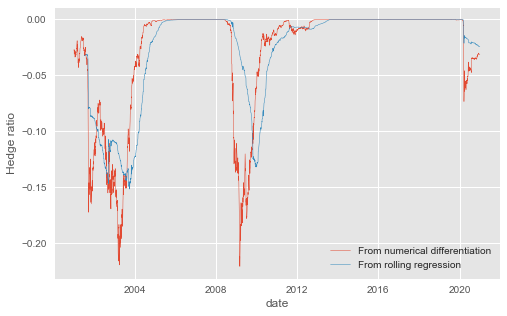

In [160]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(dfboeing['date'], dfboeing['hedge ratio (numdiff)'], linewidth=0.5)
ax.plot(dfboeing['date'], dfboeing['hedge ratio (reg)'], linewidth=0.5)
ax.set_ylabel('Hedge ratio')
ax.set_xlabel('date')
ax.legend(['From numerical differentiation', 'From rolling regression'])
# fig.subplots_adjust(left=0.2, right=0.95)
fig.savefig('Q3_b.png', dpi=150)

In [92]:

threshold = 3
maxholdingdays = 22
winsize = 250
minobs = 125
# Difference
dfboeing['diff'] = dfboeing['spread5y'] - dfboeing['CGcds']
# Rolling mean and standard deviation
dfboeing['diff_mean'] = dfboeing['diff'].rolling(window=winsize, min_periods=minobs).mean()
dfboeing['diff_std'] = dfboeing['diff'].rolling(window=winsize, min_periods=minobs).std(doff=1)
dfboeing['diff_z'] = (dfboeing['diff'] - dfboeing['diff_mean']) / dfboeing['diff_std']
# Arrays used for the strategy
diff_z = dfboeing['diff_z'].to_numpy()
# Strategy if market CDS spread is high


In [104]:

def arb_ret(df, maxholdingdays, threshold):
    diff_z = dfboeing['diff_z'].to_numpy()
    trigger1 = np.zeros(dfboeing.shape[0], dtype='int')
    pos1 = np.zeros(dfboeing.shape[0], dtype='int')
    df_calc = df.copy()
    for i in range(df_calc.shape[0]):
        if diff_z[i] > threshold and np.isfinite(diff_z[i]) and (i > 0 and trigger1[i-1] == 0):
            trigger1[i] = 1
            pos1[i] = 1
        if i > 0 and pos1[i-1] != 0 and pos1[i-1] < maxholdingdays:
            pos1[i] = pos1[i-1] + 1
        if pos1[i] != 1:
            trigger1[i] = 0
# Strategy if market CDS spread is low
    trigger2 = np.zeros(df_calc.shape[0], dtype='int')
    pos2 = np.zeros(df_calc.shape[0], dtype='int')
    for i in range(df_calc.shape[0]):
        if diff_z[i] < -threshold and np.isfinite(diff_z[i]) and (i > 0 and trigger2[i-1] == 0):
            trigger2[i] = 1
            pos2[i] = 1
        if i > 0 and pos2[i-1] != 0 and pos2[i-1] < maxholdingdays:
            pos2[i] = pos2[i-1] + 1
        if pos2[i] != 1:
            trigger2[i] = 0
    df_calc['trigger1'] = trigger1
    df_calc['trigger2'] = trigger2
    df_calc['pos1'] = pos1
    df_calc['pos2'] = pos2
    # Calculate cumulative stock return in the next month
    df_calc['stkret'] = df_calc['S']/df_calc['S'].shift(1)-1
    df_calc['fret1m'] = df_calc.rolling(window=maxholdingdays)['stkret'].apply(lambda x: 100*((1+x).prod()-1)).shift(-maxholdingdays)
    # Calculate cumulative CDS return in the next month
    df_calc['dcdsret'] = (df_calc['spread5y'] - df_calc['spread5y'].shift(1)) * df_calc['rpv01']
    df_calc['fcds1m'] = df_calc.rolling(window=maxholdingdays)['dcdsret'].sum().shift(-maxholdingdays)
    # Calculate arbitrage portfolio return
    df_calc['Arbitrage return'] = np.nan
    mask1 = df_calc['trigger1'] == 1
    df_calc.loc[mask1, 'caparb'] = df_calc.loc[mask1, 'fret1m'] * df_calc.loc[mask1, 'hedge ratio (reg)'] - df_calc.loc[mask1, 'fcds1m']
    mask2 = df_calc['trigger2'] == 1
    df_calc.loc[mask2, 'caparb'] = -df_calc.loc[mask2, 'fret1m'] * df_calc.loc[mask2, 'hedge ratio (reg)'] + df_calc.loc[mask2, 'fcds1m']
    # Print results
    outtab1 = df_calc.dropna(subset=['caparb']).loc[mask1, 'caparb'].describe().to_frame('High market CDS')
    outtab2 = df_calc.dropna(subset=['caparb']).loc[mask2, 'caparb'].describe().to_frame('Low market CDS')
    outtab = df_calc.dropna(subset=['caparb'])['caparb'].describe().to_frame('Arbitrage return (%)')
    outtaball = pd.concat([outtab1, outtab2, outtab], axis=1)

    return (df_calc, outtaball)

## Figure

<AxesSubplot:xlabel='date', ylabel='value'>

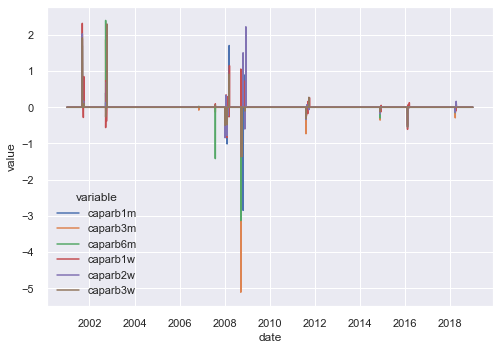

In [195]:
import seaborn as sns

hold_period_1m = arb_ret(dfboeing,22, 3)[0]
hold_period_3m = arb_ret(dfboeing,66, 3)[0]
hold_period_6m = arb_ret(dfboeing,126, 3)[0]
hold_period_1w = arb_ret(dfboeing,5, 3)[0]
hold_period_2w = arb_ret(dfboeing,10, 3)[0]
hold_period_3w = arb_ret(dfboeing,15, 3)[0]

exret_all_df = pd.concat(
    [hold_period_1m[['date','caparb']],
    hold_period_3m['caparb'],
    hold_period_6m['caparb'],
    hold_period_1w['caparb'],
    hold_period_2w['caparb'],
    hold_period_3w['caparb']],axis=1
    )
exret_all_df.columns = ['date', 'caparb1m','caparb3m','caparb6m','caparb1w','caparb2w','caparb3w']
exret_all_df = exret_all_df.fillna(0)
caparb_2018 = exret_all_df[exret_all_df['date'] < '2019'].copy()
caparb_2020 = exret_all_df[exret_all_df['date'] >= '2019'].copy()
#exret_all_df = exret_all_df.set_index('date')
#sns.set_theme()
sns.lineplot(
    x='date',y='value', hue='variable',
    data=pd.melt(caparb_2018,['date']))

#### Data Mining CapArb

In [137]:
# Data Mining Summary Table
## threshold 3
hold_period = pd.DataFrame(np.zeros((1, 6)), columns=['1w', '2w', '3w', '1m', '3m','6m'], index=['3'])
hold_period['1m'] = arb_ret(dfboeing,22, 3)[1]['Arbitrage return (%)']['mean']
hold_period['3m'] = arb_ret(dfboeing, 66, 3)[1]['Arbitrage return (%)']['mean']
hold_period['6m'] = arb_ret(dfboeing, 126, 3)[1]['Arbitrage return (%)']['mean']
hold_period['1w'] = arb_ret(dfboeing, 5, 3)[1]['Arbitrage return (%)']['mean']
hold_period['2w'] = arb_ret(dfboeing, 10, 3)[1]['Arbitrage return (%)']['mean']
hold_period['3w'] = arb_ret(dfboeing, 15, 3)[1]['Arbitrage return (%)']['mean']
## threhsold 1
thred1_1m = arb_ret(dfboeing,22, 1)[1]['Arbitrage return (%)']['mean']
thred1_3m = arb_ret(dfboeing, 66, 1)[1]['Arbitrage return (%)']['mean']
thred1_6m = arb_ret(dfboeing, 126, 1)[1]['Arbitrage return (%)']['mean']
thred1_1w = arb_ret(dfboeing, 5, 1)[1]['Arbitrage return (%)']['mean']
thred1_2w = arb_ret(dfboeing, 10, 1)[1]['Arbitrage return (%)']['mean']
thred1_3w = arb_ret(dfboeing, 15, 1)[1]['Arbitrage return (%)']['mean']
hold_period.loc['1'] = [thred1_1m, thred1_3m, thred1_6m, thred1_1w, thred1_2w, thred1_3w]
## threshold 0.5
thred05_1m = arb_ret(dfboeing,22, .5)[1]['Arbitrage return (%)']['mean']
thred05_3m = arb_ret(dfboeing, 66, .5)[1]['Arbitrage return (%)']['mean']
thred05_6m = arb_ret(dfboeing, 126, .5)[1]['Arbitrage return (%)']['mean']
thred05_1w = arb_ret(dfboeing, 5, .5)[1]['Arbitrage return (%)']['mean']
thred05_2w = arb_ret(dfboeing, 10, .5)[1]['Arbitrage return (%)']['mean']
thred05_3w = arb_ret(dfboeing, 15, .5)[1]['Arbitrage return (%)']['mean']
hold_period.loc['.5'] = [thred05_1m, thred05_3m, thred05_6m, thred05_1w, thred05_2w, thred05_3w]

In [153]:
hold_period.to_csv('holdperiod1.csv')

In [144]:
hold_period.iloc[0,:].values

array([-0.19651448, -0.37564176, -0.37810095, -0.90279036, -1.5747706 ,
       -1.07243471])

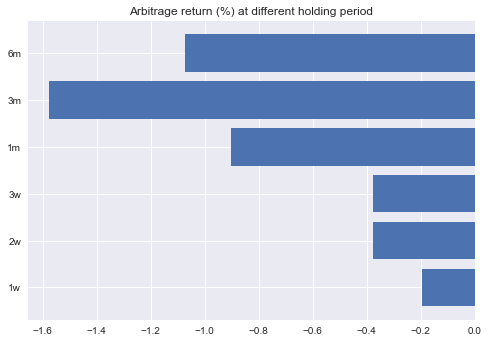

In [152]:
#plt.plot(np.arange(1,7,1),hold_period.iloc[0,:].values)
plt.barh(np.arange(1,7,1), hold_period.iloc[0,:].values, tick_label = hold_period.iloc[0,:].index.tolist())
plt.title('Arbitrage return (%) at different holding period')
plt.style.use('ggplot')
plt.show()

In [16]:
#hold_period

,1w,2w,3w,1m,3m,6m
3,-0.196514,-0.375642,-0.322525,-0.881094,-1.574771,-1.120469
1,-0.149088,-0.471588,-0.966269,-0.042200,-0.084398,-0.130391
.5,-0.157976,-0.313714,-0.670787,-0.036005,-0.073100,-0.107128


#### IS testing

In [25]:
from scipy.optimize import Bounds
from scipy.optimize import minimize
from IS_model import *
from IS_tools import *
import warnings
warnings.filterwarnings("ignore")

df_prcdis = dfboeing.copy()
df_prcdis = df_prcdis[['spread5y','CGcds']].copy()
df_prcdis.index = pd.DatetimeIndex(dfboeing['date'])

In [80]:
def calc_information_shares(test_data):
    model = InfoShares(test_data,'aic',maxLag=20,deterministic='ci')
    res = model.fit()
    return pd.Series(res.MInfoShares.A1,index = test_data.columns)

In [81]:
IS1, IS2= [], []
df_prcdis
for start, end in zip(np.arange(0, len(df_prcdis)-250), np.arange(250, len(df_prcdis)+1)):
    df = df_prcdis[start:end+1].copy()
    is1, is2 = calc_information_shares(df)
    IS1.append(is1)
    IS2.append(is2)

In [86]:
series = df_prcdis.index
for start, end in zip(np.arange(0, len(df_prcdis)-250), np.arange(250, len(df_prcdis)+1)):
    date = series[end]
    df_prcdis.loc[date,'IS1'] = IS1[start]
    df_prcdis.loc[date,'IS2'] = IS2[start]


In [97]:
dfboeing['hedge ratio (reg)']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
5026   -0.024141
5027   -0.024151
5028   -0.024159
5029   -0.024196
5030   -0.024154
Name: hedge ratio (reg), Length: 5031, dtype: float64

In [118]:
df_prcdis['hedge ratio (reg)'] = dfboeing['hedge ratio (reg)'].values
df_prcdis['diff_z'] = dfboeing['diff_z'].values
df_prcdis['S'] = dfboeing['S'].values
df_prcdis['rpv01'] = dfboeing['rpv01'].values

In [119]:

df_prcdis

,spread5y,CGcds,IS1,IS2,hedge ratio,diff_z,S,rpv01,hedge ratio (reg)
date,,,,,,,,,
2001-01-02,0.303333,0.203715,NaN,NaN,NaN,NaN,62.00000,4.431792,NaN
2001-01-03,0.276250,0.199167,NaN,NaN,NaN,NaN,62.56250,4.413162,NaN
2001-01-04,0.276250,0.197391,NaN,NaN,NaN,NaN,61.00000,4.425997,NaN
2001-01-05,0.276250,0.218785,NaN,NaN,NaN,NaN,58.75000,4.440808,NaN
2001-01-08,0.276250,0.213850,NaN,NaN,NaN,NaN,59.00000,4.442382,NaN
...,...,...,...,...,...,...,...,...,...
2020-12-24,1.573541,8.675829,0.920476,0.079524,-0.024141,-1.284178,217.14999,3.388824,-0.024141
2020-12-28,1.587706,8.685881,0.920606,0.079394,-0.024151,-1.272483,216.09000,3.386670,-0.024151
2020-12-29,1.584025,8.682953,0.923368,0.076632,-0.024159,-1.262517,216.25000,3.387218,-0.024159


In [113]:

def arb_ret2(df, maxholdingdays, threshold_z, threshold_IS):
    df_calc = df.copy()
    
    diff_z = dfboeing['diff_z'].to_numpy()
    
    ## also check is cds integration inbound
    cds_IS = df_prcdis['IS1'].to_numpy()

    trigger1 = np.zeros(dfboeing.shape[0], dtype='int')
    pos1 = np.zeros(dfboeing.shape[0], dtype='int')
    for i in range(df_calc.shape[0]):
        if diff_z[i] > threshold_z and np.isfinite(diff_z[i]) and (i > 0 and trigger1[i-1] == 0) \
                and (cds_IS[i] <= threshold_IS or cds_IS[i] >= (1-threshold_IS)):
            trigger1[i] = 1
            pos1[i] = 1
        if i > 0 and pos1[i-1] != 0 and pos1[i-1] < maxholdingdays:
            pos1[i] = pos1[i-1] + 1
        if pos1[i] != 1:
            trigger1[i] = 0
    # Strategy if market CDS spread is low
    trigger2 = np.zeros(df_calc.shape[0], dtype='int')
    pos2 = np.zeros(df_calc.shape[0], dtype='int')
    for i in range(df_calc.shape[0]):
        if diff_z[i] < -threshold_z and np.isfinite(diff_z[i]) and (i > 0 and trigger2[i-1] == 0)\
                and (cds_IS[i] <= threshold_IS or cds_IS[i] >= (1-threshold_IS)):
            trigger2[i] = 1
            pos2[i] = 1
        if i > 0 and pos2[i-1] != 0 and pos2[i-1] < maxholdingdays:
            pos2[i] = pos2[i-1] + 1
        if pos2[i] != 1:
            trigger2[i] = 0

    


    df_calc['trigger1'] = trigger1
    df_calc['trigger2'] = trigger2
    
    df_calc['pos1'] = pos1
    df_calc['pos2'] = pos2

    # Calculate cumulative stock return in the next month
    df_calc['stkret'] = df_calc['S']/df_calc['S'].shift(1)-1
    df_calc['fret1m'] = df_calc.rolling(window=maxholdingdays)['stkret'].apply(lambda x: 100*((1+x).prod()-1)).shift(-maxholdingdays)
    # Calculate cumulative CDS return in the next month
    df_calc['dcdsret'] = (df_calc['spread5y'] - df_calc['spread5y'].shift(1)) * df_calc['rpv01']
    df_calc['fcds1m'] = df_calc.rolling(window=maxholdingdays)['dcdsret'].sum().shift(-maxholdingdays)
    # Calculate arbitrage portfolio return
    df_calc['Arbitrage return'] = np.nan
    mask1 = df_calc['trigger1'] == 1
    df_calc.loc[mask1, 'caparb'] = df_calc.loc[mask1, 'fret1m'] * df_calc.loc[mask1, 'hedge ratio (reg)'] - df_calc.loc[mask1, 'fcds1m']
    mask2 = df_calc['trigger2'] == 1
    df_calc.loc[mask2, 'caparb'] = -df_calc.loc[mask2, 'fret1m'] * df_calc.loc[mask2, 'hedge ratio (reg)'] + df_calc.loc[mask2, 'fcds1m']
    # Print results
    outtab1 = df_calc.dropna(subset=['caparb']).loc[mask1, 'caparb'].describe().to_frame('High market CDS')
    outtab2 = df_calc.dropna(subset=['caparb']).loc[mask2, 'caparb'].describe().to_frame('Low market CDS')
    outtab = df_calc.dropna(subset=['caparb'])['caparb'].describe().to_frame('Arbitrage return (%)')
    outtaball = pd.concat([outtab1, outtab2, outtab], axis=1)
    
    #temp1 = dfboeing.dropna(subset=['caparb']).loc[mask2, ['date', 'caparb']]
    
    return (df_calc, outtaball)
    

In [127]:
# Data Mining Summary Table
## threshold 3,
hold_period2 = pd.DataFrame(np.zeros((1, 6)), columns=['1w', '2w', '3w', '1m', '3m','6m'], index=['3'])
hold_period2['1m'] = arb_ret2(df_prcdis,22, 3, .2)[1]['Arbitrage return (%)']['mean']
hold_period2['3m'] = arb_ret2(df_prcdis, 66, 3, .2)[1]['Arbitrage return (%)']['mean']
hold_period2['6m'] = arb_ret2(df_prcdis, 126, 3, .2)[1]['Arbitrage return (%)']['mean']
hold_period2['1w'] = arb_ret2(df_prcdis, 5, 3, .2)[1]['Arbitrage return (%)']['mean']
hold_period2['2w'] = arb_ret2(df_prcdis, 10, 3, .2)[1]['Arbitrage return (%)']['mean']
hold_period2['3w'] = arb_ret2(df_prcdis, 15, 3, .2)[1]['Arbitrage return (%)']['mean']
## threhsold 1
thred1_1m = arb_ret2(df_prcdis,22, 1, .2)[1]['Arbitrage return (%)']['mean']
thred1_3m = arb_ret2(df_prcdis, 66, 1, .2)[1]['Arbitrage return (%)']['mean']
thred1_6m = arb_ret2(df_prcdis, 126, 1, .2)[1]['Arbitrage return (%)']['mean']
thred1_1w = arb_ret2(df_prcdis, 5, 1, .2)[1]['Arbitrage return (%)']['mean']
thred1_2w = arb_ret2(df_prcdis, 10, 1, .2)[1]['Arbitrage return (%)']['mean']
thred1_3w = arb_ret2(df_prcdis, 15, 1, .2)[1]['Arbitrage return (%)']['mean']
hold_period2.loc['1'] = [thred1_1m, thred1_3m, thred1_6m, thred1_1w, thred1_2w, thred1_3w]
## threshold 0.5, 
thred05_1m = arb_ret2(df_prcdis,22, .5, .2)[1]['Arbitrage return (%)']['mean']
thred05_3m = arb_ret2(df_prcdis, 66, .5, .2)[1]['Arbitrage return (%)']['mean']
thred05_6m = arb_ret2(df_prcdis, 126, .5, .2)[1]['Arbitrage return (%)']['mean']
thred05_1w = arb_ret2(df_prcdis, 5, .5, .2)[1]['Arbitrage return (%)']['mean']
thred05_2w = arb_ret2(df_prcdis, 10, .5, .2)[1]['Arbitrage return (%)']['mean']
thred05_3w = arb_ret2(df_prcdis, 15, .5, .2)[1]['Arbitrage return (%)']['mean']
hold_period2.loc['.5'] = [thred05_1m, thred05_3m, thred05_6m, thred05_1w, thred05_2w, thred05_3w]

In [155]:
hold_period2.to_csv('hold_period2.csv')

In [128]:
hold_period2

,1w,2w,3w,1m,3m,6m
3,-0.166558,-0.259056,-0.583109,-1.031446,-1.932871,-1.372561
1,-0.205057,-0.618311,-0.964129,-0.061515,-0.117945,-0.156597
.5,-0.195240,-0.369506,-0.531703,-0.042180,-0.096097,-0.101053


In [125]:
# Data Mining Summary Table
## threshold 3,
hold_period3 = pd.DataFrame(np.zeros((1, 6)), columns=['1w', '2w', '3w', '1m', '3m','6m'], index=['3'])
hold_period3['1m'] = arb_ret2(df_prcdis,22, 3, .05)[1]['Arbitrage return (%)']['mean']
hold_period3['3m'] = arb_ret2(df_prcdis, 66, 3, .05)[1]['Arbitrage return (%)']['mean']
hold_period3['6m'] = arb_ret2(df_prcdis, 126, 3, .05)[1]['Arbitrage return (%)']['mean']
hold_period3['1w'] = arb_ret2(df_prcdis, 5, 3, .05)[1]['Arbitrage return (%)']['mean']
hold_period3['2w'] = arb_ret2(df_prcdis, 10, 3, .05)[1]['Arbitrage return (%)']['mean']
hold_period3['3w'] = arb_ret2(df_prcdis, 15, 3, .05)[1]['Arbitrage return (%)']['mean']
## threhsold 1
thred1_1m = arb_ret2(df_prcdis,22, 1, .05)[1]['Arbitrage return (%)']['mean']
thred1_3m = arb_ret2(df_prcdis, 66, 1, .05)[1]['Arbitrage return (%)']['mean']
thred1_6m = arb_ret2(df_prcdis, 126, 1, .05)[1]['Arbitrage return (%)']['mean']
thred1_1w = arb_ret2(df_prcdis, 5, 1, .05)[1]['Arbitrage return (%)']['mean']
thred1_2w = arb_ret2(df_prcdis, 10, 1, .05)[1]['Arbitrage return (%)']['mean']
thred1_3w = arb_ret2(df_prcdis, 15, 1, .05)[1]['Arbitrage return (%)']['mean']
hold_period3.loc['1'] = [thred1_1m, thred1_3m, thred1_6m, thred1_1w, thred1_2w, thred1_3w]
## threshold 0.5, 
thred05_1m = arb_ret2(df_prcdis,22, .5, .05)[1]['Arbitrage return (%)']['mean']
thred05_3m = arb_ret2(df_prcdis, 66, .5, .05)[1]['Arbitrage return (%)']['mean']
thred05_6m = arb_ret2(df_prcdis, 126, .5, .05)[1]['Arbitrage return (%)']['mean']
thred05_1w = arb_ret2(df_prcdis, 5, .5, .05)[1]['Arbitrage return (%)']['mean']
thred05_2w = arb_ret2(df_prcdis, 10, .5, .05)[1]['Arbitrage return (%)']['mean']
thred05_3w = arb_ret2(df_prcdis, 15, .5, .05)[1]['Arbitrage return (%)']['mean']
hold_period3.loc['.5'] = [thred05_1m, thred05_3m, thred05_6m, thred05_1w, thred05_2w, thred05_3w]

In [156]:
hold_period3.to_csv('hold3.csv')

In [126]:
hold_period3.to_csv('hold3.csv')

,1w,2w,3w,1m,3m,6m
3,-0.600706,-1.430216,-1.124595,-1.098772,-1.860217,-1.616578
1,0.096283,-0.519347,-0.581897,-0.046504,-0.096031,0.010478
.5,0.035525,-0.580652,-0.742129,-0.044682,-0.082983,-0.052856


In [130]:

def arb_ret3(df, maxholdingdays, threshold_z, threshold_IS):
    df_calc = df.copy()
    
    diff_z = dfboeing['diff_z'].to_numpy()
    
    ## also check is cds integration inbound
    cds_IS = df_prcdis['IS1'].to_numpy()
    ## short cds
    trigger1 = np.zeros(dfboeing.shape[0], dtype='int')
    pos1 = np.zeros(dfboeing.shape[0], dtype='int')
    for i in range(df_calc.shape[0]):
        if diff_z[i] > threshold_z and np.isfinite(diff_z[i]) and (i > 0 and trigger1[i-1] == 0) \
                and (cds_IS[i] <= threshold_IS):
            trigger1[i] = 1
            pos1[i] = 1
        if i > 0 and pos1[i-1] != 0 and pos1[i-1] < maxholdingdays:
            pos1[i] = pos1[i-1] + 1
        if pos1[i] != 1:
            trigger1[i] = 0
    ## short equity
    trigger2 = np.zeros(df_calc.shape[0], dtype='int')
    pos2 = np.zeros(df_calc.shape[0], dtype='int')
    for i in range(df_calc.shape[0]):
        if diff_z[i] > threshold_z and np.isfinite(diff_z[i]) and (i > 0 and trigger2[i-1] == 0)\
                and (cds_IS[i] >= (1-threshold_IS)):
            trigger2[i] = 1
            pos2[i] = 1
        if i > 0 and pos2[i-1] != 0 and pos2[i-1] < maxholdingdays:
            pos2[i] = pos2[i-1] + 1
        if pos2[i] != 1:
            trigger2[i] = 0
    ## long equity
    trigger3 = np.zeros(df_calc.shape[0], dtype='int')
    pos3 = np.zeros(df_calc.shape[0], dtype='int')
    for i in range(df_calc.shape[0]):
        if diff_z[i] < -threshold_z and np.isfinite(diff_z[i]) and (i > 0 and trigger3[i-1] == 0)\
                and (cds_IS[i] <= (1-threshold_IS)):
            trigger3[i] = 1
            pos3[i] = 1
        if i > 0 and pos3[i-1] != 0 and pos3[i-1] < maxholdingdays:
            pos3[i] = pos3[i-1] + 1
        if pos3[i] != 1:
            trigger3[i] = 0
    ### long scd
    trigger4 = np.zeros(df_calc.shape[0], dtype='int')
    pos4 = np.zeros(df_calc.shape[0], dtype='int')
    for i in range(df_calc.shape[0]):
        if diff_z[i] < -threshold_z and np.isfinite(diff_z[i]) and (i > 0 and trigger4[i-1] == 0)\
                and (cds_IS[i] >= (1-threshold_IS)):
            trigger4[i] = 1
            pos4[i] = 1
        if i > 0 and pos4[i-1] != 0 and pos4[i-1] < maxholdingdays:
            pos4[i] = pos2[i-1] + 1
        if pos4[i] != 1:
            trigger4[i] = 0


    df_calc['trigger1'] = trigger1
    df_calc['trigger2'] = trigger2
    df_calc['trigger3'] = trigger3
    df_calc['trigger4'] = trigger4    
    df_calc['pos1'] = pos1
    df_calc['pos2'] = pos2
    df_calc['pos3'] = pos3
    df_calc['pos4'] = pos4
    # Calculate cumulative stock return in the next month
    df_calc['stkret'] = df_calc['S']/df_calc['S'].shift(1)-1
    df_calc['fret1m'] = df_calc.rolling(window=maxholdingdays)['stkret'].apply(lambda x: 100*((1+x).prod()-1)).shift(-maxholdingdays)
    # Calculate cumulative CDS return in the next month
    df_calc['dcdsret'] = (df_calc['spread5y'] - df_calc['spread5y'].shift(1)) * df_calc['rpv01']
    df_calc['fcds1m'] = df_calc.rolling(window=maxholdingdays)['dcdsret'].sum().shift(-maxholdingdays)
    # Calculate arbitrage portfolio return
    #df_calc['Arbitrage return'] = np.nan
    mask1 = df_calc['trigger1'] == 1
    df_calc.loc[mask1, 'caparb'] =  - df_calc.loc[mask1, 'fcds1m']
    mask2 = df_calc['trigger2'] == 1
    df_calc.loc[mask2, 'caparb'] = -df_calc.loc[mask2, 'fret1m'] * df_calc.loc[mask2, 'hedge ratio (reg)']
    mask3 = df_calc['trigger3'] == 1
    df_calc.loc[mask3, 'caparb'] = df_calc.loc[mask3, 'fcds1m']
    mask4 = df_calc['trigger4'] == 1
    df_calc.loc[mask4, 'caparb'] = df_calc.loc[mask4, 'fret1m'] * df_calc.loc[mask4, 'hedge ratio (reg)']
    # Print results
    outtab1 = df_calc.dropna(subset=['caparb']).loc[mask1, 'caparb'].describe().to_frame('High market Short CDS')
    outtab2 = df_calc.dropna(subset=['caparb']).loc[mask2, 'caparb'].describe().to_frame('High market Short Equity')
    outtab3 = df_calc.dropna(subset=['caparb']).loc[mask3, 'caparb'].describe().to_frame('Low market Long CDS')
    outtab4 = df_calc.dropna(subset=['caparb']).loc[mask4, 'caparb'].describe().to_frame('Low market Long Equity')
    outtab = df_calc.dropna(subset=['caparb'])['caparb'].describe().to_frame('Arbitrage return (%)')
    outtaball = pd.concat([outtab1, outtab2, outtab3, outtab4, outtab], axis=1)
    
    return (df_calc, outtaball)
    

In [131]:
# Data Mining Summary Table
## threshold 3,
hold_period4 = pd.DataFrame(np.zeros((1, 6)), columns=['1w', '2w', '3w', '1m', '3m','6m'], index=['3'])
hold_period4['1m'] = arb_ret3(df_prcdis,22, 3, .2)[1]['Arbitrage return (%)']['mean']
hold_period4['3m'] = arb_ret3(df_prcdis, 66, 3, .2)[1]['Arbitrage return (%)']['mean']
hold_period4['6m'] = arb_ret3(df_prcdis, 126, 3, .2)[1]['Arbitrage return (%)']['mean']
hold_period4['1w'] = arb_ret3(df_prcdis, 5, 3, .2)[1]['Arbitrage return (%)']['mean']
hold_period4['2w'] = arb_ret3(df_prcdis, 10, 3, .2)[1]['Arbitrage return (%)']['mean']
hold_period4['3w'] = arb_ret3(df_prcdis, 15, 3, .2)[1]['Arbitrage return (%)']['mean']
## threhsold 1
thred1_1m = arb_ret3(df_prcdis,22, 1, .2)[1]['Arbitrage return (%)']['mean']
thred1_3m = arb_ret3(df_prcdis, 66, 1, .2)[1]['Arbitrage return (%)']['mean']
thred1_6m = arb_ret3(df_prcdis, 126, 1, .2)[1]['Arbitrage return (%)']['mean']
thred1_1w = arb_ret3(df_prcdis, 5, 1, .2)[1]['Arbitrage return (%)']['mean']
thred1_2w = arb_ret3(df_prcdis, 10, 1, .2)[1]['Arbitrage return (%)']['mean']
thred1_3w = arb_ret3(df_prcdis, 15, 1, .2)[1]['Arbitrage return (%)']['mean']
hold_period4.loc['1'] = [thred1_1m, thred1_3m, thred1_6m, thred1_1w, thred1_2w, thred1_3w]
## threshold 0.5, 
thred05_1m = arb_ret3(df_prcdis,22, .5, .2)[1]['Arbitrage return (%)']['mean']
thred05_3m = arb_ret3(df_prcdis, 66, .5, .2)[1]['Arbitrage return (%)']['mean']
thred05_6m = arb_ret3(df_prcdis, 126, .5, .2)[1]['Arbitrage return (%)']['mean']
thred05_1w = arb_ret3(df_prcdis, 5, .5, .2)[1]['Arbitrage return (%)']['mean']
thred05_2w = arb_ret3(df_prcdis, 10, .5, .2)[1]['Arbitrage return (%)']['mean']
thred05_3w = arb_ret3(df_prcdis, 15, .5, .2)[1]['Arbitrage return (%)']['mean']
hold_period4.loc['.5'] = [thred05_1m, thred05_3m, thred05_6m, thred05_1w, thred05_2w, thred05_3w]

In [157]:
hold_period4.to_csv('hold4.csv')

In [132]:
hold_period4

,1w,2w,3w,1m,3m,6m
3,-0.040485,-0.044310,-0.184283,0.013627,-0.858238,-1.175355
1,-0.022675,0.113913,0.022658,-0.015443,-0.024194,-0.016953
.5,-0.009718,0.034108,-0.061592,-0.013225,-0.014013,-0.011176


In [133]:
# Data Mining Summary Table
## threshold 3,
hold_period5 = pd.DataFrame(np.zeros((1, 6)), columns=['1w', '2w', '3w', '1m', '3m','6m'], index=['3'])
hold_period5['1m'] = arb_ret3(df_prcdis,22, 3, .05)[1]['Arbitrage return (%)']['mean']
hold_period5['3m'] = arb_ret3(df_prcdis, 66, 3, .05)[1]['Arbitrage return (%)']['mean']
hold_period5['6m'] = arb_ret3(df_prcdis, 126, 3, .05)[1]['Arbitrage return (%)']['mean']
hold_period5['1w'] = arb_ret3(df_prcdis, 5, 3, .05)[1]['Arbitrage return (%)']['mean']
hold_period5['2w'] = arb_ret3(df_prcdis, 10, 3, .05)[1]['Arbitrage return (%)']['mean']
hold_period5['3w'] = arb_ret3(df_prcdis, 15, 3, .05)[1]['Arbitrage return (%)']['mean']
## threhsold 1
thred1_1m = arb_ret3(df_prcdis,22, 1, .05)[1]['Arbitrage return (%)']['mean']
thred1_3m = arb_ret3(df_prcdis, 66, 1, .05)[1]['Arbitrage return (%)']['mean']
thred1_6m = arb_ret3(df_prcdis, 126, 1, .05)[1]['Arbitrage return (%)']['mean']
thred1_1w = arb_ret3(df_prcdis, 5, 1, .05)[1]['Arbitrage return (%)']['mean']
thred1_2w = arb_ret3(df_prcdis, 10, 1, .05)[1]['Arbitrage return (%)']['mean']
thred1_3w = arb_ret3(df_prcdis, 15, 1, .05)[1]['Arbitrage return (%)']['mean']
hold_period5.loc['1'] = [thred1_1m, thred1_3m, thred1_6m, thred1_1w, thred1_2w, thred1_3w]
## threshold 0.5, 
thred05_1m = arb_ret3(df_prcdis,22, .5, .05)[1]['Arbitrage return (%)']['mean']
thred05_3m = arb_ret3(df_prcdis, 66, .5, .05)[1]['Arbitrage return (%)']['mean']
thred05_6m = arb_ret3(df_prcdis, 126, .5, .05)[1]['Arbitrage return (%)']['mean']
thred05_1w = arb_ret3(df_prcdis, 5, .5, .05)[1]['Arbitrage return (%)']['mean']
thred05_2w = arb_ret3(df_prcdis, 10, .5, .05)[1]['Arbitrage return (%)']['mean']
thred05_3w = arb_ret3(df_prcdis, 15, .5, .05)[1]['Arbitrage return (%)']['mean']
hold_period5.loc['.5'] = [thred05_1m, thred05_3m, thred05_6m, thred05_1w, thred05_2w, thred05_3w]

In [134]:
hold_period5

,1w,2w,3w,1m,3m,6m
3,0.096735,0.037043,0.090322,0.026696,-0.931422,-1.273022
1,-0.001921,0.089835,0.023778,-0.013047,-0.030875,0.009313
.5,0.011884,0.092635,0.033485,-0.006294,-0.001594,0.016866


In [158]:
hold_period5.to_csv('hold5.csv')

In [159]:
arb_ret3(df_prcdis,22, 3, .05)[1]#['Arbitrage return (%)']['mean']

,High market Short CDS,High market Short Equity,Low market Long CDS,Low market Long Equity,Arbitrage return (%)
count,6.000000,7.000000,4.000000,5.000000,22.000000
mean,-0.432883,0.012168,0.620193,0.123732,0.026696
std,0.596318,0.029273,1.938694,0.163891,0.869892
min,-1.568328,-0.018707,-0.841407,-0.120104,-1.568328
25%,-0.515075,-0.001720,-0.315566,0.081248,-0.116412
50%,-0.181680,0.000039,-0.077180,0.134176,-0.002193
75%,-0.074163,0.023944,0.858578,0.198350,0.056509
max,-0.001082,0.059398,3.476538,0.324987,3.476538


## Strategy Comparison

In [176]:
CSA_thred05_2w = arb_ret(dfboeing, 10, .5)[0]
S2_thred05_2w = arb_ret2(df_prcdis, 10, .5, .05)[0].reset_index()
S3_thred05_2w = arb_ret3(df_prcdis, 10, .5, .05)[0].reset_index()#['Arbitrage return (%)']['mean']

550

In [199]:
import seaborn as sns
exret_all_df = pd.concat(
    [CSA_thred05_2w[['date','caparb']],
    S2_thred05_2w['caparb'],
    S3_thred05_2w['caparb'],],axis=1
    )
exret_all_df.columns = ['date', 'Strategy 1','Strategy 2','Strategy 3']
exret_all_df = exret_all_df.fillna(0)


In [200]:
exret_all_df

,date,Strategy 1,Strategy 2,Strategy 3
0,2001-01-02,0.0,0.0,0.0
1,2001-01-03,0.0,0.0,0.0
2,2001-01-04,0.0,0.0,0.0
3,2001-01-05,0.0,0.0,0.0
4,2001-01-08,0.0,0.0,0.0
...,...,...,...,...
5026,2020-12-24,0.0,0.0,0.0
5027,2020-12-28,0.0,0.0,0.0
5028,2020-12-29,0.0,0.0,0.0
5029,2020-12-30,0.0,0.0,0.0


In [201]:
caparb_2006 = exret_all_df[(exret_all_df['date'] < '2006')].copy()
caparb_2012 = exret_all_df[(exret_all_df['date'] >= '2006') & (exret_all_df['date'] < '2012')].copy()
caparb_2018 = exret_all_df[(exret_all_df['date'] >= '2012 ') & (exret_all_df['date'] < '2018')].copy()
caparb_2020 = exret_all_df[(exret_all_df['date'] >= '2018 ')].copy()
#exret_all_df = exret_all_df.set_index('date')
#sns.set_theme()


<AxesSubplot:xlabel='date', ylabel='value'>

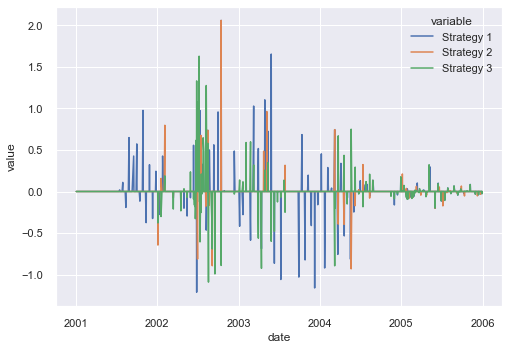

In [202]:
#sns.set_style('')
sns.lineplot(
    x='date',y='value', hue='variable',
    data=pd.melt(caparb_2006,['date']))

<AxesSubplot:xlabel='date', ylabel='value'>

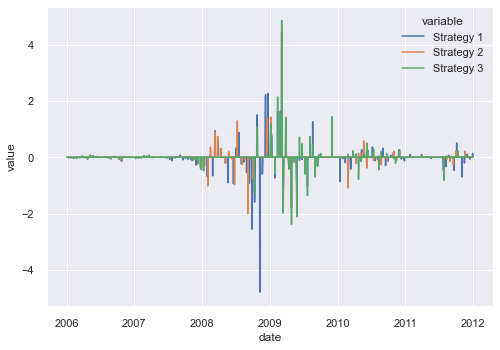

In [203]:
sns.lineplot(
    x='date',y='value', hue='variable',
    data=pd.melt(caparb_2012,['date']))

<AxesSubplot:xlabel='date', ylabel='value'>

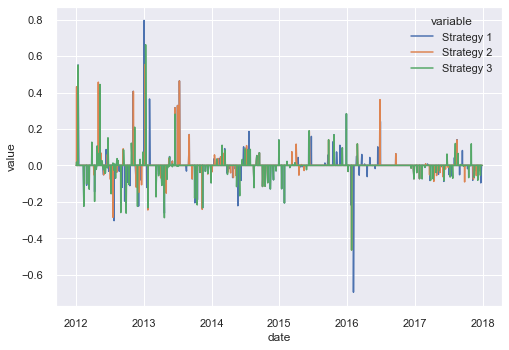

In [204]:
sns.lineplot(
    x='date',y='value', hue='variable',
    data=pd.melt(caparb_2018,['date']))

<AxesSubplot:xlabel='date', ylabel='value'>

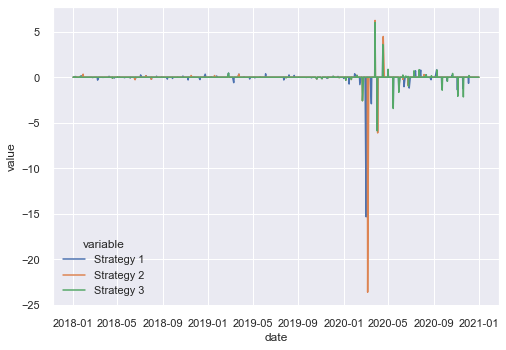

In [205]:
sns.lineplot(
    x='date',y='value', hue='variable',
    data=pd.melt(caparb_2020,['date']))